**Fáza 3 - strojové učenie**

Michaela Hanková, Martin Rudolf

50%:50%

cvičenie: piatok 10:00

dataset: 163

In [497]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pylab
import scipy.stats as stats
from matplotlib.pyplot import figure 
from sklearn.impute import SimpleImputer
from numpy import isnan
from sklearn.preprocessing import LabelEncoder, StandardScaler 
import category_encoders as ce
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVR
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score

In [69]:
data_labor = pd.read_csv("163/labor.csv", sep='\t', index_col=0)
data_labor['smoker'] = data_labor['smoker'].str.replace('Y','yes')
data_labor['smoker'] = data_labor['smoker'].str.replace('N','no')
data_labor['relationship'] = data_labor['relationship'].str.replace('divoced','divorced')
data_labor = data_labor.drop_duplicates()

In [70]:
data_profiles = pd.read_csv(r"163/profiles.csv", sep='\t', index_col=0)
# v stĺpcoch address a residence boli v záznamoch znaky '\n' , nahradím tento znak medzerou
data_profiles['address'] = data_profiles['address'].replace(r'\s+|\\n', ' ', regex=True)
data_profiles['residence'] = data_profiles['residence'].replace(r'\s+|\\n', ' ', regex=True)
# nastavenie rovnakého formátu pre dátumy
data_profiles['birthdate'] = pd.to_datetime(data_profiles['birthdate'])
# upravenie hodnoty v stĺpci 'race' z blsck na Black, black na Black, white na White
data_profiles['race'] = data_profiles['race'].str.replace('blsck','Black')
data_profiles['race'] = data_profiles['race'].str.replace('black','Black')
data_profiles['race'] = data_profiles['race'].str.replace('white','White')

In [71]:
spojene_datasety = data_labor.set_index('ssn').join(data_profiles.set_index('ssn'), rsuffix = 'name')
spojene_datasety = spojene_datasety.drop(columns = 'namename', axis = 1)

In [72]:
df_deleted_dup = spojene_datasety[~spojene_datasety.index.duplicated()]

In [73]:
spojene_datasety.corr()

,leukocyty,hemoglobin,trombocyty,indicator,alt,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
leukocyty,1.000000,0.004640,-0.014721,0.015860,-0.004818,-0.011178,0.002531,0.000989,-0.015768,-0.009489,0.007969,0.012035,-0.005183
hemoglobin,0.004640,1.000000,-0.025521,0.341538,-0.003252,0.016932,0.000555,-0.229272,-0.377629,-0.406118,0.000632,-0.002817,0.193101
trombocyty,-0.014721,-0.025521,1.000000,-0.013625,0.012614,0.008477,0.008704,0.006070,0.016667,0.007110,-0.021420,0.014990,-0.004625
indicator,0.015860,0.341538,-0.013625,1.000000,-0.062122,0.004941,0.000201,0.075600,-0.342863,-0.001359,-0.006138,-0.004004,-0.003483
alt,-0.004818,-0.003252,0.012614,-0.062122,1.000000,-0.000318,-0.004409,-0.106587,0.073943,0.066469,-0.017070,0.015463,0.447086
weight,-0.011178,0.016932,0.008477,0.004941,-0.000318,1.000000,-0.010877,0.011238,0.006388,0.014668,-0.002592,-0.011031,-0.005883
ast,0.002531,0.000555,0.008704,0.000201,-0.004409,-0.010877,1.000000,0.006996,0.010907,0.006823,0.007899,-0.014574,0.006656
alp,0.000989,-0.229272,0.006070,0.075600,-0.106587,0.011238,0.006996,1.000000,0.046733,0.134554,-0.011134,-0.001320,-0.190029
hematokrit,-0.015768,-0.377629,0.016667,-0.342863,0.073943,0.006388,0.010907,0.046733,1.000000,0.354859,0.007639,-0.003259,0.110563
hbver,-0.009489,-0.406118,0.007110,-0.001359,0.066469,0.014668,0.006823,0.134554,0.354859,1.000000,-0.025003,0.002978,-0.021696


In [74]:
df_deleted_dup = spojene_datasety[~spojene_datasety.index.duplicated()]

In [75]:
training_data = pd.read_csv(r"163/vystupny_subor_faza2.csv", sep=',', index_col=0)
training_data

,hbver,hematokrit,hemoglobin,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5,relationship_6,race_1,race_2,race_3,race_4,race_5,indicator
ssn,,,,,,,,,,,,,,,
128-16-9378,-0.542387,0.008266,0.251671,0,1,0,0,0,0,1,0,0,0,0,0.0
018-97-8963,0.726616,-0.247722,1.523024,0,0,1,0,0,0,1,0,0,0,0,1.0
556-31-6142,-1.087965,1.370296,-0.027712,0,0,1,0,0,0,0,1,0,0,0,1.0
031-81-9828,0.374879,0.056590,-1.071897,0,0,0,0,1,0,1,0,0,0,0,0.0
370-55-2861,0.332131,1.265549,0.194724,0,0,0,1,0,0,1,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236-65-6676,0.459898,-0.430227,-0.001574,0,0,0,0,1,0,1,0,0,0,0,1.0
765-93-0321,-0.347321,-0.562923,-0.130947,0,1,0,0,0,0,1,0,0,0,0,1.0
027-39-8294,-0.221250,-1.023942,-0.794246,0,1,0,0,0,0,0,1,0,0,0,1.0


In [76]:
testing_data = pd.read_csv("163/testing_data.csv", sep=',', index_col=0)
testing_data

,hbver,hematokrit,hemoglobin,relationship_1,relationship_2,relationship_3,relationship_4,relationship_5,relationship_6,race_1,race_2,race_3,race_4,race_5,indicator
ssn,,,,,,,,,,,,,,,
590-74-3232,-1.405363,-1.433465,0.548537,0,1,0,0,0,0,1,0,0,0,0,1.0
161-97-9650,-1.206707,-0.803934,0.233909,1,0,0,0,0,0,0,1,0,0,0,1.0
212-47-3356,-1.393887,-1.783561,1.028053,0,0,0,0,0,1,0,1,0,0,0,1.0
108-57-9254,-0.502491,-0.891597,0.681541,0,0,1,0,0,0,0,1,0,0,0,1.0
790-11-0276,-1.289416,-0.192163,0.006481,0,0,0,0,0,1,1,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
569-74-1084,-1.471549,1.629638,0.112926,0,1,0,0,0,0,1,0,0,0,0,0.0
642-69-9445,-0.090921,-0.833694,-1.871213,0,0,0,0,1,0,1,0,0,0,0,1.0
755-48-1605,0.506579,0.499510,0.117980,0,1,0,0,0,0,1,0,0,0,0,1.0


/Users/pc/Documents/IAU/env/iau_env/lib/python3.9/site-packages/seaborn/distributions.py:967: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
/Users/pc/Documents/IAU/env/iau_env/lib/python3.9/site-packages/seaborn/distributions.py:1015: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  artist = ax.fill_between(
/Users/pc/Documents/IAU/env/iau_env/lib/python3.9/site-packages/seaborn/distributions.py:967: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  scout = self.ax.fill_between([], [], **plot_kws)
/Users/pc/Documents/IAU/env/iau_env/lib/python3.9/site-packages/seaborn/distributions.py:1015: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and suppo

<AxesSubplot:xlabel='hematokrit', ylabel='Density'>

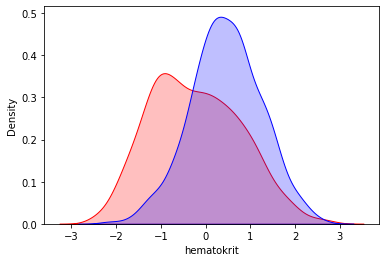

In [77]:
# Plotting the KDE Plot
sns.kdeplot(training_data.loc[(training_data['indicator'] == 1.0), 'hematokrit'],
            color='r', shade=True, Label='chory')
  
sns.kdeplot(training_data.loc[(training_data['indicator'] == 0.0), 'hematokrit'],
            color='b', shade=True, Label='zdravy')

Najvyššiu koreláciu s atribútom indicator má hematokrit

Na základe hodnoty hematokritu prepíšeme indikátor na 1.0 (ak je hematokrit menší ako 0) alebo na 0.0

In [78]:
def singleRule(dataset):
    vysledok = pd.Series()
    pocet = 0
    for i, riadok in dataset.iterrows():
        if (riadok["indicator"] in [1.0, 0.0]):
            if (riadok["hematokrit"] < 0):
                vysledok = vysledok.append(pd.Series([1.0])) 
            elif (riadok["hematokrit"] >= 0):
                vysledok = vysledok.append(pd.Series([0.0])) 
    return vysledok

Do povodny_indikator uložím indikátory z testovacieho datasetu. Potom testovacie dáta pošlem do funkcie, ktorá prepíše
indikátory na základe toho, či je hematokrit väčší alebo menší ako 0. Ak je >=0, pacient by mal byť zdravý.

In [79]:
spravne = testing_data["indicator"].dropna()
predikcie = singleRule(testing_data)

print(accuracy_score(spravne, predikcie))
print(precision_score(spravne, predikcie, average="macro"))
print(recall_score(spravne, predikcie, average="macro"))
print(classification_report(spravne,predikcie))


/var/folders/y3/vbvqzdrx4cdcdsdr7ttt6ytr0000gn/T/ipykernel_13194/4086370876.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vysledok = pd.Series()


0.6517954298150164
0.6505816376795119
0.6678705698475056
              precision    recall  f1-score   support

         0.0       0.49      0.72      0.58       312
         1.0       0.81      0.62      0.70       607

    accuracy                           0.65       919
   macro avg       0.65      0.67      0.64       919
weighted avg       0.70      0.65      0.66       919



In [109]:
X_training = training_data.drop('indicator', axis = 'columns')
y_training = training_data['indicator']
X_testing = testing_data.drop('indicator', axis = 'columns')
y_testing = testing_data['indicator']
feature_names = list(training_data.dtypes.index.values)

#vitvorime klasifikator a natrenujeme ho s trenovacimi datami
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_training, y_training)

[Text(637.3706896551724, 489.24, 'hemoglobin <= -0.98\ngini = 0.454\nsamples = 2143\nvalue = [748, 1395]'),
 Text(264.5689655172414, 380.52000000000004, 'hematokrit <= -0.438\ngini = 0.376\nsamples = 351\nvalue = [263, 88]'),
 Text(96.20689655172414, 271.8, 'hematokrit <= -0.731\ngini = 0.142\nsamples = 39\nvalue = [3, 36]'),
 Text(48.10344827586207, 163.08000000000004, 'gini = 0.0\nsamples = 28\nvalue = [0, 28]'),
 Text(144.31034482758622, 163.08000000000004, 'hematokrit <= -0.567\ngini = 0.397\nsamples = 11\nvalue = [3, 8]'),
 Text(96.20689655172414, 54.360000000000014, '\n  (...)  \n'),
 Text(192.41379310344828, 54.360000000000014, '\n  (...)  \n'),
 Text(432.93103448275866, 271.8, 'hbver <= 1.405\ngini = 0.278\nsamples = 312\nvalue = [260, 52]'),
 Text(336.7241379310345, 163.08000000000004, 'hematokrit <= 2.437\ngini = 0.226\nsamples = 270\nvalue = [235, 35]'),
 Text(288.62068965517244, 54.360000000000014, '\n  (...)  \n'),
 Text(384.82758620689657, 54.360000000000014, '\n  (...)  

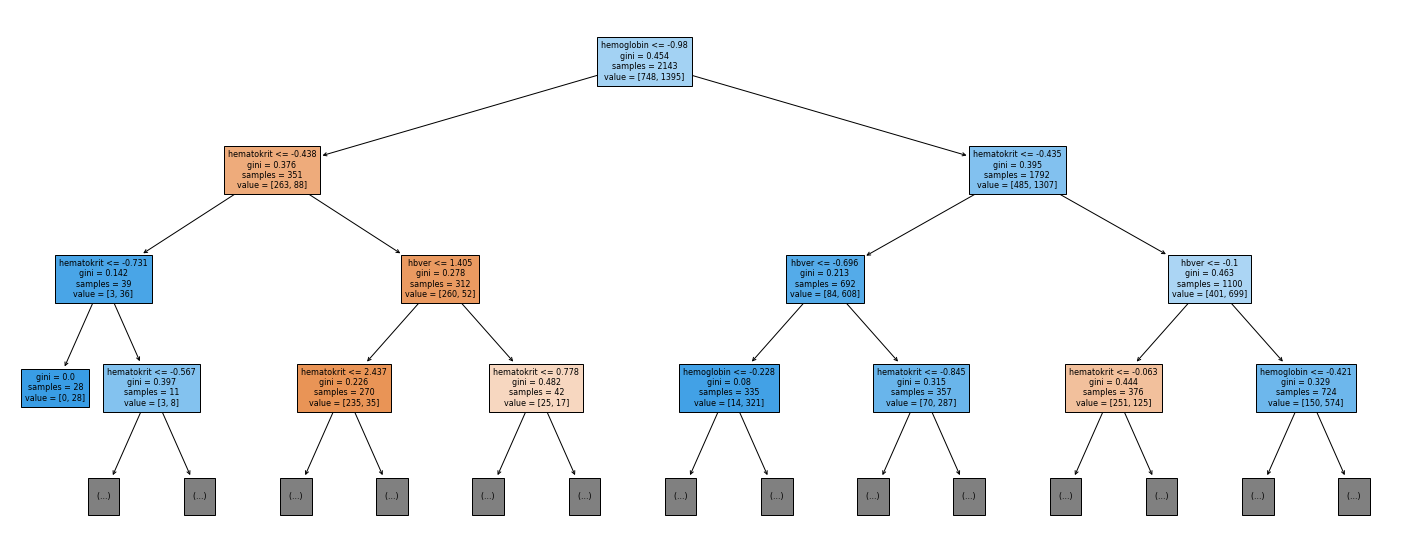

In [118]:
#vizualizacia modelu len do hlbky 3 hlbsie je problem vizualizovat kvoli komlexnosti modelu
fig = plt.figure(figsize=(25,10))
tree.plot_tree(clf, max_depth = 3, filled = True, feature_names=feature_names, fontsize = 8)

## Porovnanie 1R a DecisionTreeClassfier
Keď porovnáme náš implementovaný 1R klasifikátor s natrenovaným rozhodovacím stromom tak dôjdeme k záveru, že náš algoritmus zaostáva o viac ako 10%, čo nám potvrdzujú všetky pozorované metriky, accuracy, precision a recall. 
Tieto metriky vyhodnocujú úspešnosť na základe týchto formúl:
$Accuracy = \frac{TP+TN}{TP+FP+FN+TN}$
$Precision = \frac{TP}{TP+FP}$
$Recall = \frac{TP}{TP+FN}$

In [119]:
#vyskusame nas model na testovacich datach a pozrieme sa na uspesnost
y_pred = clf.predict(X_testing)

print("accuracy score je: %f" % accuracy_score(y_testing, y_pred))
print("precision score je: %f" % precision_score(y_testing, y_pred, average="macro"))
print("recall score je: %f" % recall_score(y_testing, y_pred, average="macro"))
print(classification_report(y_testing,y_pred))

accuracy score je: 0.779108
precision score je: 0.753895
precision score je: 0.750227
              precision    recall  f1-score   support

         0.0       0.68      0.66      0.67       312
         1.0       0.83      0.84      0.83       607

    accuracy                           0.78       919
   macro avg       0.75      0.75      0.75       919
weighted avg       0.78      0.78      0.78       919



## Trénovanie klasifikátora strojového učenia a hyperparameter tunning
Najprv si vyextrahujeme názvy atribútov ktore rozdelíme na kategorické a numerické aby sme si podľa nich mohli nastaviť pipeline. Potom si rozdelíme data na testovaciu a trénovaciu vzorku. Testovaciu vzorku použíjeme až po experimentoch a hyperparameter tunning. Experimenty vykonávame len na trenóvacich dátach za asistencie K-fold cross validácie aby sme predišli pretrénovaniu. Ešte pred samotnými experimentami si nastavíme pipeline na metódy s ktorýmki si chceme predspracovať naše atribúty. Následne ak sme spokojný s natrenovaným modelom alebo už pomocou nastavovania hyperparametrov viac z neho nevieme vymačknuť tak ho odtestujeme na testovacích dátach. 


In [136]:
num_data = pd.read_csv("163/numeric_data.csv", sep=',', index_col=0)
cat_data = pd.read_csv("163/categoric_data.csv", sep=',', index_col=0)
df = num_data.merge(cat_data, on='ssn')
df = df.drop('job', axis='columns')

In [137]:
#vyextrahujeme si numericke a kategoricke atributy aby sme si pre ne mohli neskor nastavit pipeline
cat_cols = list(df.dtypes[df.dtypes == 'object'].index.values)
num_cols = list(df.dtypes[df.dtypes != 'object'].index.values)
num_cols.remove('indicator')

for col in cat_cols:
    df[col] = df[col].astype('category')

X = df[df.columns.difference(['indicator'])]
y = df['indicator']
#rozdelime si data na trenovacie a tetovacie
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)



## Nastavenie hyperparametrov decision tree klasifikátoru 

**criterion** tento parameter meria kvalitu rozdelenia datasetu. Podporované hodnoty su string "gini" a "entropy". Štúdie hovoria že rozdiel medzi možnosťami tohto parametru nie sú preukázateľné na výkone, no v našm prípade sme zaznamenali lepšie výsledky s hodnotou entropy ktorá meria kvalitu rozdelenia logaritmickou funkciou preto môže byŤ výpoČet o čosi pomalší. 
### Gini: $Gini(E) = 1 - \sum_{j=1}^c p_j^2$
### Entropy: $H(E) = - \sum_{j=1}^c p_j log{}{p_j}$

**splitter** parameter je vlatne sposob akým sa budu rozdeľovať uzly v strome. String hodnotou tohto parametru je "random" alebo "best". Pri naŠích experimentoch sme sa zhodli na parametri hodnote "best" z dôvodu lešíeho výkonu o niekoľko stotín. Tento parameter používa random uniform function a na jej vstupe prijíma mean_feature_value max_feature_value a random_state, všetky tieto vstupne parametre su taktiež hyperparametramy celého klasifikátora.

**max_depth** s týmto parametrom môžme bojovať s overfittingom alebo s underfittingom. Hodnotou tohto parametra je celočíselná hodnota alebo príznak None. Ak máme pocit že dochádza k overfittingu tak zredukujeme hodnotu tohto parametra, no ak dochádza k underfittingu tak naopak boostneme túto hodnotu.

**min_samples_split** hovorí o minimapnom pocte vzoriek v uzle. Týmto parametrom vieme kontrolovaŤ taktiež over/underfitting, kde vysoké hodnoty môžu spôsobovaŤ underfitting. Niektoré štúdia tvrdia že ideálne hodnoty pre tento parameter sú medzi 1 až 40. Pri naších experimentoch sme došli k hodnote 30 pri ktorej sme generovali najlepšie výsledky.

**min_samples_leaf** definuje minimálny počet vzoriek potrebných na uzle reprezentujúcom list stromu. Tým že na každom liste bude viac než jeden element viem takisto predísŤ overfittingu. Štúdia hovorí že tento parameter spolu s hyperparametrom **min_samples_split** majú najväčší vplyv na úspešnosť modelu, čo sa nám aj potvrdilo po experimentoch s týmito hyperparametrami, ktoré nám boostli úspešnoť približne o 5%. 

**max_features** hodnotami sú int, float, string (auto, sqrt, log2, None), ktoré hovoria o počte atribútov potrebných na najlepšie rozdelenie. Pri našom pozorovaní sme zistili, že čím zväčšujeme číslo tohto parametru tým máme aj lepšiu úspešnosť modelu. Najlepšie výsledky sme ale odpozorovali pre deafultnú hodnotu tohto parametru teda None.

**random_state** požijeme celočíselnú hodnotu ak chcem určíť od akého zákaldu sa odpichne generátor náhodných čísel s ktorým pracuje. Obľúbenou hodnotou pre tento parameter je 42, no po niekoľkých experimentoch s týmto parametrom sme ostali pri defaultnej hodnote keďže nám generovala najväčší úspech modelu.

In [492]:
numerical = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

column_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical, num_cols),
        ('cat', OneHotEncoder(), cat_cols)])

clf = Pipeline(steps=[('preprocessor', column_preprocessor),
                      ('classifier', tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=7, min_samples_split=30, min_samples_leaf=13, 
                                                                 min_weight_fraction_leaf=0, max_features=None, random_state=None))])

In [493]:
from sklearn import set_config
set_config(display='diagram')
clf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['leukocyty', 'hemoglobin',
                                                   'trombocyty', 'alt', 'ast',
                                                   'hematokrit', 'hbver',
                                                   'etytr', 'er-cv',
                                                   'erytrocyty', 'smoker',
                                                   'sex']),
                                                 ('cat', OneHotEncoder(),
                                                  ['relationship',
                                                   'blood_group', 'race'])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=7,
                                        min_samples_leaf=13,
                                        min_samples_split=30,
                                        min_weight_fraction_leaf=0))])

In [494]:
clf_model = clf.fit(X_train, y_train)


In [495]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['accuracy', 'precision_macro', 'recall_macro']
scores = cross_validate(clf_model, X_train, y_train, cv=5, scoring=scoring)

print("test accuracy score je: %f" % scores['test_accuracy'].mean())
print("test precision score je: %f" % scores['test_precision_macro'].mean())
print("recall score je: %f" % scores['test_recall_macro'].mean())

test accuracy score je: 0.822682
test precision score je: 0.805116
recall score je: 0.798657


In [434]:
y_pred = clf_model.predict(X_test)


accuracy score je: 0.822633
precision score je: 0.807058
recall score je: 0.805794
              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75       328
         1.0       0.86      0.86      0.86       591

    accuracy                           0.82       919
   macro avg       0.81      0.81      0.81       919
weighted avg       0.82      0.82      0.82       919



/Users/pc/Documents/IAU/env/iau_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


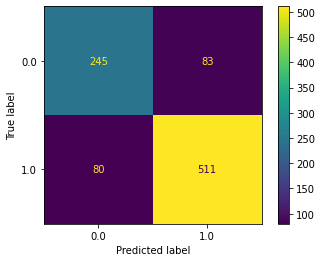

In [498]:
print("accuracy score je: %f" % accuracy_score(y_test, y_pred))
print("precision score je: %f" % precision_score(y_test, y_pred, average="macro"))
print("recall score je: %f" % recall_score(y_test, y_pred, average="macro"))
print(classification_report(y_test,y_pred))
plot_confusion_matrix(clf_model, X_test, y_test)